In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd   
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
#scalars used 
cg = 1.78
eps = 1e-2
laplace_scale = 1.0 / (2**.5)

In [3]:
#setting seed
np.random.seed(50)

In [20]:
2*((2*cg)**.5)**2

7.12

## Helper Functions

In [4]:
def random_generator(n,a,gamma=(2*cg)**.5):
    """Draws n random numbers from normal, laplace and 
    cauchy distributions with parameter a"""
    distributions = {}
    distributions['normal'] = a + np.random.randn(n)
    distributions['laplace'] = a + np.random.laplace(size = n,scale = laplace_scale)
    distributions['cauchy'] = a + scipy.stats.cauchy.rvs(size=n,loc = 0, scale = gamma)
    return distributions

def cauchy_likelihood(data, gamma, a):
    """Likelihood function of cauchy distribution"""
    return -np.sum(np.log(1 + ((data-a)/gamma)**2))

def f(data,gamma,a):
    """Optimization function for the cauchy distribution (given gamma)."""
    return np.sum((a-data)/(1 + ((data-a)/gamma)**2))

def df_da(data,gamma,a):
    """derivative of f with respect to a."""
    return np.sum((1 - ((data-a)/gamma)**2)/((1 + ((data-a)/gamma)**2)**2))

def nr(data,guess,gamma,iterations=1000):
    """Newton-Raphson method for estimating the location parameter of a Cauchy distribution."""
    for iteration in range(iterations):
        y = f(data,gamma, guess)
        dy_dA = df_da(data, gamma, guess)
        guess -= y/dy_dA
        if abs(y) < eps:
            break
    return guess

def grad_desc(data,guess,gamma,iterations=1000):
    """gradient descent method for estimating the location parameter of a cauchy distribution."""
    lr = 1e-3
    pguess = 1e5
    for _ in range(iterations):
        y = f(data,gamma, guess)
        pguess = guess
        guess -= lr*y
        if abs(pguess-guess) < eps:
            break
    return guess

def mle_estimates(distributions, gamma, guess):
    """Calculates the mle estimates for normal, laplace and cauchy distributions."""
    estimates = {}
    for key in distributions.keys():
        if key == 'normal':
            estimates[key] = np.mean(distributions[key])
        elif key == 'laplace':
            estimates[key] = np.median(distributions[key])
        elif key == 'cauchy':
            estimates[key] = nr(distributions[key], guess, gamma=gamma,iterations=10000)
    return estimates

def Fisher_information(n):
    """Calculates the fisher information for the cauchy distribution."""
    return {"normal" : 1/n, "laplace": 2/n,  "cauchy": 4*cg } # "cauchy": 1/(2*gamma**2)

## Experiments

In [13]:
# from tqdm import tqdm

def realisations(n, a, num_realisations):
    """Generates n random numbers and calculates MLE estimates for num_realisations."""
    estimates = {"normal": [], "laplace": [], "cauchy": []}
    
    for _ in tqdm(
        range(num_realisations),
        desc=f"n={n} | Realisations",
        leave=False,
        dynamic_ncols=True,
    ):
        distributions = random_generator(n, a)
        estimate = mle_estimates(distributions, gamma=(2 * cg) ** 0.5, guess=np.median(distributions["cauchy"]))


        for key in estimate:
            estimates[key].append(estimate[key])
    
    return estimates

def get_statistics(estimates):
    """Calculates mean and standard deviation of MLE estimates."""
    statistics = {}
    for key in estimates:
        statistics[key] = {
            'mean': np.mean(estimates[key]),
            'var': np.var(estimates[key])
        }
    return statistics

def iter_over_sample_size(ns, a, num_realisations):
    """Iterates over different sample sizes and calculates MLE estimates."""
    estimates = {}
    stats = {}

    outer = tqdm(ns, desc="Sample Sizes", dynamic_ncols=True)
    for n in outer:
        outer.set_description(f"Sample size: n={n}")
        estimates[n] = realisations(n, a, num_realisations)
        stats[n] = get_statistics(estimates[n])
        outer.write(f"Done: n={n}, num_real={num_realisations}")
    
    return estimates, stats

def give_results(a, sample_sizes, num_realisations):
    data = {}
    for ni in sample_sizes:
        data[f"{ni}"]={}
        for nri in num_realisations:
            data[f"{ni}"][f"normal_{nri}"]={}
            data[f"{ni}"][f"laplace_{nri}"]={}
            data[f"{ni}"][f"cauchy_{nri}"]={}
            
    for nr in num_realisations:
        estimates, stats = iter_over_sample_size(sample_sizes, a, nr)
        for ni in sample_sizes:
            data[f"{ni}"][f"normal_{nr}"] = rf'{stats[ni]["normal"]["mean"]:.3f} ± {np.sqrt(stats[ni]["normal"]["var"]):.3f}'
            data[f"{ni}"][f"laplace_{nr}"] = rf'{stats[ni]["laplace"]["mean"]:.3f} ± {np.sqrt(stats[ni]["laplace"]["var"]):.3f}'
            data[f"{ni}"][f"cauchy_{nr}"] = rf'{stats[ni]["normal"]["mean"]:.3f} ± {np.sqrt(stats[ni]["cauchy"]["var"]):.3f}'
    df = pd.DataFrame(data).T
    ordered_cols = [f"normal_{nr}" for nr in num_realisations]
    ordered_cols.extend([f"laplace_{nr}" for nr in num_realisations])
    ordered_cols.extend([f"cauchy_{nr}" for nr in num_realisations])
    df = df.loc[:,ordered_cols]
    return df, estimates, stats


## Plotting functions

In [29]:
def plot_cdf(a, data, stat ,label='CDF', color='blue', axis=None):
    """Plots the CDF of the data."""
    if axis is None:
        _, axis = plt.subplots(figsize=(5, 5), layout="constrained")
    sorted_data = np.sort(data)
    cdf = np.linspace(0, 1, len(sorted_data))
    axis.step(sorted_data, cdf, where='post', label=label, color=color)
    axis.set_xlabel(r'Value of $\hat{a}$')
    axis.set_ylabel('Cumulative Probability')
    axis.set_title(f"CDF of {label} with mean: {stat['mean']:.3E} var: {stat['var']:.3E}")
    axis.set_xlim(max(-3+a,np.min(data)), min(3+a,np.max(data)))

def plot_cdf_pdf(ns,a,estimates,stats):
    for n in ns:
        _, axs = plt.subplots(3, 2, figsize=(10, 5), layout="constrained")
        for i,key in enumerate(estimates[n].keys()):
            axs[i,0].hist(estimates[n][key], density=True, bins=100, alpha=0.5, color='blue', label='PDF',range=(max(-3+a,np.min(estimates[n][key])), min(3+a,np.max(estimates[n][key]))))
            axs[i,0].set_title(f"PDF of {key} with sample size {n}")
            plot_cdf(a, estimates[n][key], stats[n][key], label=key, color='blue', axis=axs[i,1])
            axs[i,1].set_title(f"CDF of {key} with sample size {n}")
        plt.show()

def plot_mean_var(stats):
    _, axs = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
    mean, var = {"normal": [], "laplace": [], "cauchy": []},{"normal": [], "laplace": [], "cauchy": []}
    for n in stats.keys():
        for key in mean.keys():
            mean[key].append(stats[n][key]['mean'])
            var[key].append(stats[n][key]['var'])
    for key in mean.keys():
        axs[0].semilogy(stats.keys(), mean[key], label=key)
        axs[1].semilogy(stats.keys(), var[key], label=key)
    axs[0].set_xlabel(r'Sample Size')
    axs[0].set_ylabel(r'Mean of $\hat{a}$')
    axs[0].set_title(r'Mean of $\hat{a}$')
    # axs[0].set_xscale(r'log')
    axs[1].set_xlabel(r'Sample Size')
    axs[1].set_ylabel(r'Variance of $\hat{a}$')
    axs[1].set_title(r'Variance of $\hat{a}$')
    # axs[1].set_xscale(r'log')
    axs[0].legend()
    axs[1].legend()
    plt.show()

In [30]:
n = [1, 10, 100, 1000, 10000]#, 1000, 10000]
num_realisations = [10,100,1000]

In [21]:
a = 1.0
df1,estimates1,stats1 = give_results(a, n, num_realisations)
df1.head()

Sample Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

n=1 | Realisations:   0%|          | 0/10 [00:00<?, ?it/s]

Done: n=1, num_real=10


n=10 | Realisations:   0%|          | 0/10 [00:00<?, ?it/s]

Done: n=10, num_real=10


n=100 | Realisations:   0%|          | 0/10 [00:00<?, ?it/s]

Done: n=100, num_real=10


n=1000 | Realisations:   0%|          | 0/10 [00:00<?, ?it/s]

Done: n=1000, num_real=10


n=10000 | Realisations:   0%|          | 0/10 [00:00<?, ?it/s]

Done: n=10000, num_real=10


Sample Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

n=1 | Realisations:   0%|          | 0/100 [00:00<?, ?it/s]

Done: n=1, num_real=100


n=10 | Realisations:   0%|          | 0/100 [00:00<?, ?it/s]

Done: n=10, num_real=100


n=100 | Realisations:   0%|          | 0/100 [00:00<?, ?it/s]

Done: n=100, num_real=100


n=1000 | Realisations:   0%|          | 0/100 [00:00<?, ?it/s]

Done: n=1000, num_real=100


n=10000 | Realisations:   0%|          | 0/100 [00:00<?, ?it/s]

Done: n=10000, num_real=100


Sample Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

n=1 | Realisations:   0%|          | 0/1000 [00:00<?, ?it/s]

Done: n=1, num_real=1000


n=10 | Realisations:   0%|          | 0/1000 [00:00<?, ?it/s]

Done: n=10, num_real=1000


n=100 | Realisations:   0%|          | 0/1000 [00:00<?, ?it/s]

Done: n=100, num_real=1000


n=1000 | Realisations:   0%|          | 0/1000 [00:00<?, ?it/s]

Done: n=1000, num_real=1000


n=10000 | Realisations:   0%|          | 0/1000 [00:00<?, ?it/s]

Done: n=10000, num_real=1000


,normal_10,normal_100,normal_1000,laplace_10,laplace_100,laplace_1000,cauchy_10,cauchy_100,cauchy_1000
1,1.069 ± 1.143,0.913 ± 0.955,0.953 ± 0.983,0.535 ± 1.032,0.921 ± 0.941,1.000 ± 0.989,1.069 ± 3.685,0.913 ± 27.636,0.953 ± 45.534
10,1.055 ± 0.275,1.009 ± 0.329,0.986 ± 0.328,0.878 ± 0.347,1.062 ± 0.269,0.993 ± 0.271,1.055 ± 1.412,1.009 ± 731.587,0.986 ± 875.964
100,1.001 ± 0.087,0.972 ± 0.088,0.998 ± 0.095,0.993 ± 0.060,1.003 ± 0.077,1.005 ± 0.076,1.001 ± 0.330,0.972 ± 0.272,0.998 ± 0.278
1000,1.006 ± 0.023,0.999 ± 0.029,1.000 ± 0.031,0.999 ± 0.022,1.002 ± 0.021,1.000 ± 0.022,1.006 ± 0.083,0.999 ± 0.084,1.000 ± 0.087
10000,1.002 ± 0.006,0.999 ± 0.010,1.000 ± 0.010,1.002 ± 0.006,1.000 ± 0.007,1.000 ± 0.007,1.002 ± 0.023,0.999 ± 0.029,1.000 ± 0.027


In [22]:
a = 10.0
df10,estimates10,stats10 = give_results(a, n, num_realisations)
df10.head()

Sample Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

n=1 | Realisations:   0%|          | 0/10 [00:00<?, ?it/s]

Done: n=1, num_real=10


n=10 | Realisations:   0%|          | 0/10 [00:00<?, ?it/s]

Done: n=10, num_real=10


n=100 | Realisations:   0%|          | 0/10 [00:00<?, ?it/s]

Done: n=100, num_real=10


n=1000 | Realisations:   0%|          | 0/10 [00:00<?, ?it/s]

Done: n=1000, num_real=10


n=10000 | Realisations:   0%|          | 0/10 [00:00<?, ?it/s]

Done: n=10000, num_real=10


Sample Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

n=1 | Realisations:   0%|          | 0/100 [00:00<?, ?it/s]

Done: n=1, num_real=100


n=10 | Realisations:   0%|          | 0/100 [00:00<?, ?it/s]

Done: n=10, num_real=100


n=100 | Realisations:   0%|          | 0/100 [00:00<?, ?it/s]

Done: n=100, num_real=100


n=1000 | Realisations:   0%|          | 0/100 [00:00<?, ?it/s]

Done: n=1000, num_real=100


n=10000 | Realisations:   0%|          | 0/100 [00:00<?, ?it/s]

Done: n=10000, num_real=100


Sample Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

n=1 | Realisations:   0%|          | 0/1000 [00:00<?, ?it/s]

Done: n=1, num_real=1000


n=10 | Realisations:   0%|          | 0/1000 [00:00<?, ?it/s]

Done: n=10, num_real=1000


n=100 | Realisations:   0%|          | 0/1000 [00:00<?, ?it/s]

Done: n=100, num_real=1000


n=1000 | Realisations:   0%|          | 0/1000 [00:00<?, ?it/s]

Done: n=1000, num_real=1000


n=10000 | Realisations:   0%|          | 0/1000 [00:00<?, ?it/s]

Done: n=10000, num_real=1000


normal_10      normal_100     normal_1000      laplace_10  \
1       9.591 ± 0.752  10.112 ± 1.008  10.038 ± 1.004   9.824 ± 0.990   
10     10.065 ± 0.286   9.914 ± 0.332   9.990 ± 0.322   9.978 ± 0.274   
100     9.968 ± 0.120   9.991 ± 0.104  10.001 ± 0.100  10.009 ± 0.076   
1000   10.003 ± 0.019  10.001 ± 0.033   9.999 ± 0.029  10.000 ± 0.018   
10000   9.996 ± 0.006   9.999 ± 0.010  10.000 ± 0.010   9.998 ± 0.005   

         laplace_100    laplace_1000          cauchy_10        cauchy_100  \
1      9.964 ± 0.983   9.991 ± 0.971      9.591 ± 8.235   10.112 ± 21.849   
10     9.952 ± 0.262  10.009 ± 0.266  10.065 ± 2490.576  9.914 ± 1218.230   
100    9.995 ± 0.070  10.000 ± 0.075      9.968 ± 0.353     9.991 ± 0.231   
1000   9.998 ± 0.022  10.000 ± 0.023     10.003 ± 0.092    10.001 ± 0.079   
10000  9.998 ± 0.006  10.000 ± 0.007      9.996 ± 0.033     9.999 ± 0.027   

            cauchy_1000  
1       10.038 ± 60.952  
10     9.990 ± 1347.813  
100      10.001 ± 0.280  
1000      9.999 ± 0.084  
10000    10.000 ± 0.026

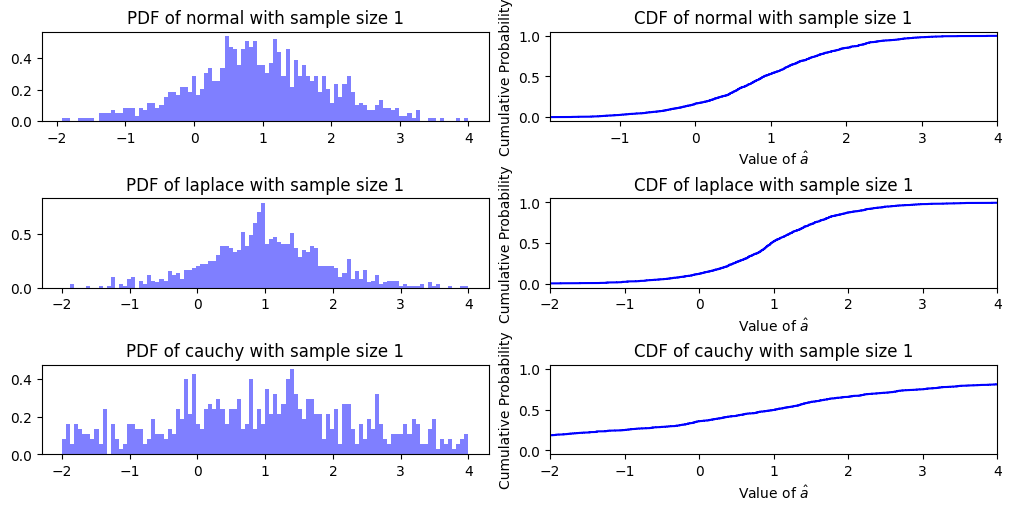

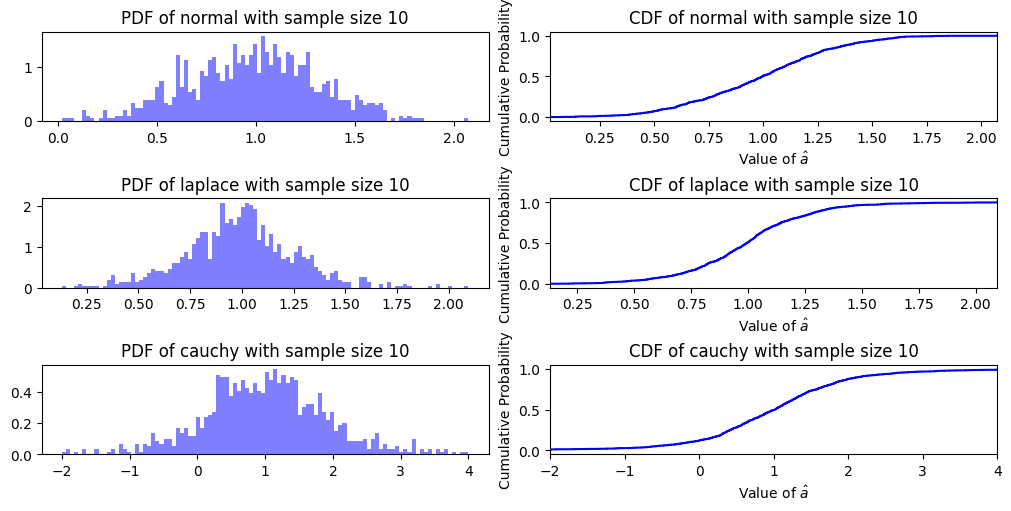

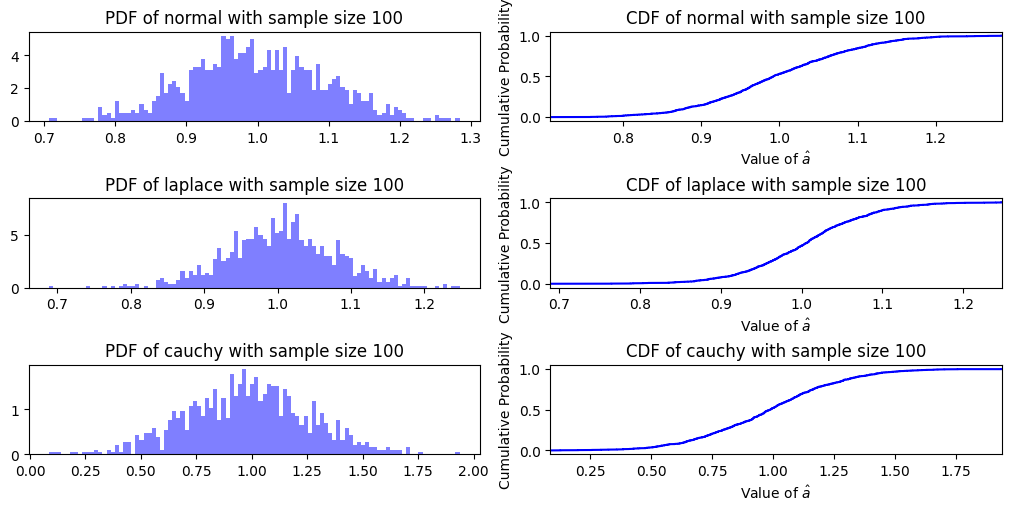

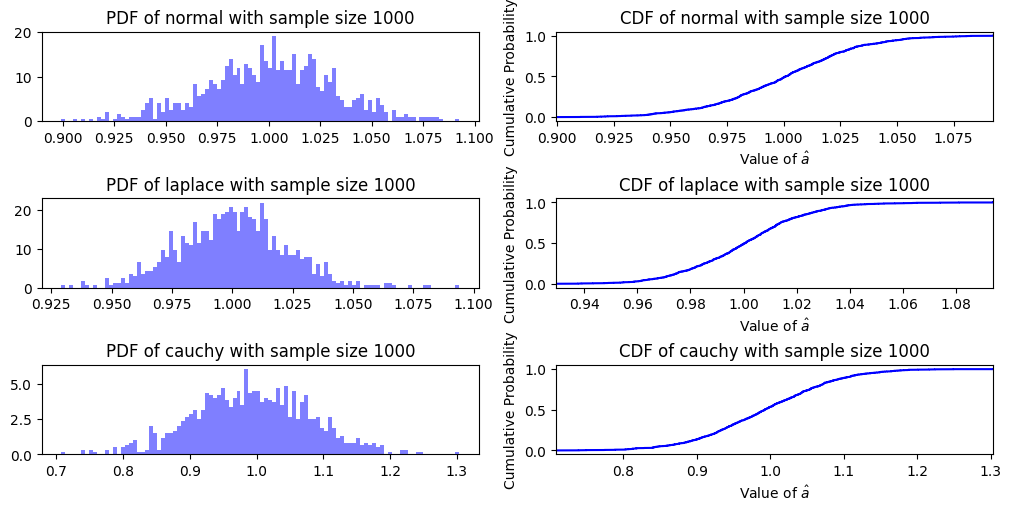

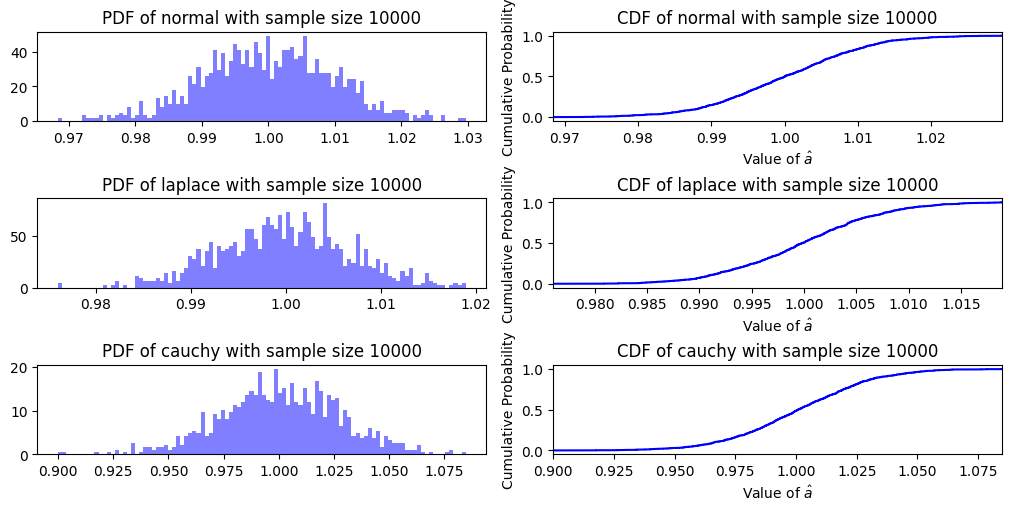

In [31]:
plot_cdf_pdf(n, 1, estimates1, stats1)

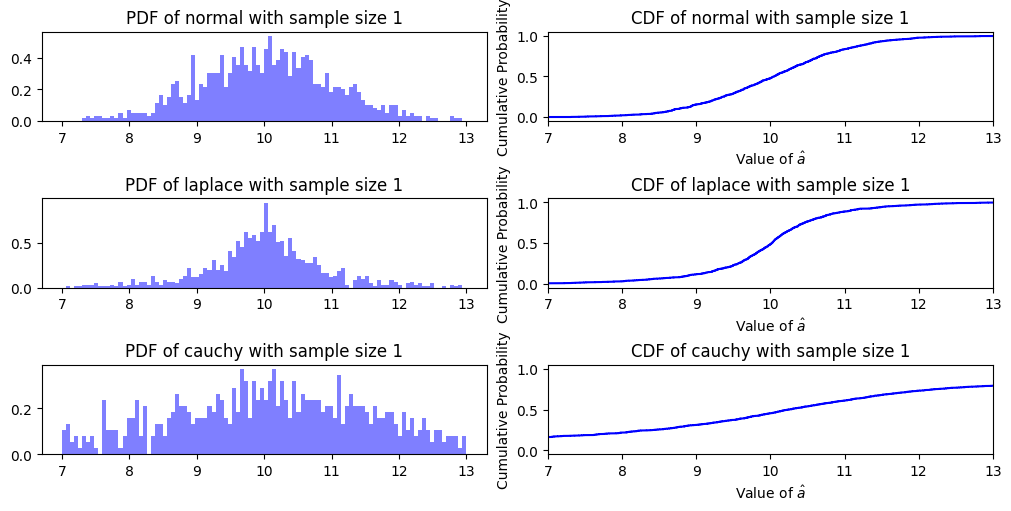

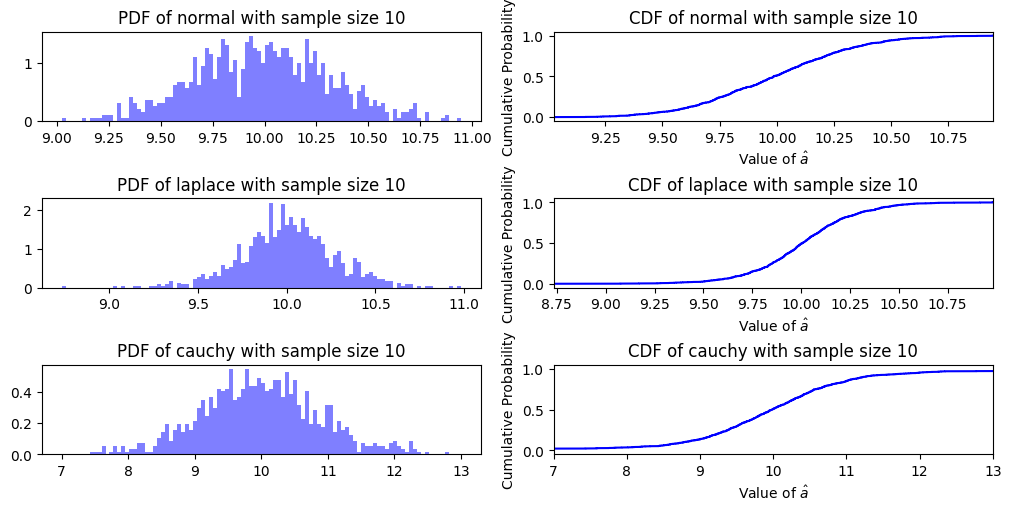

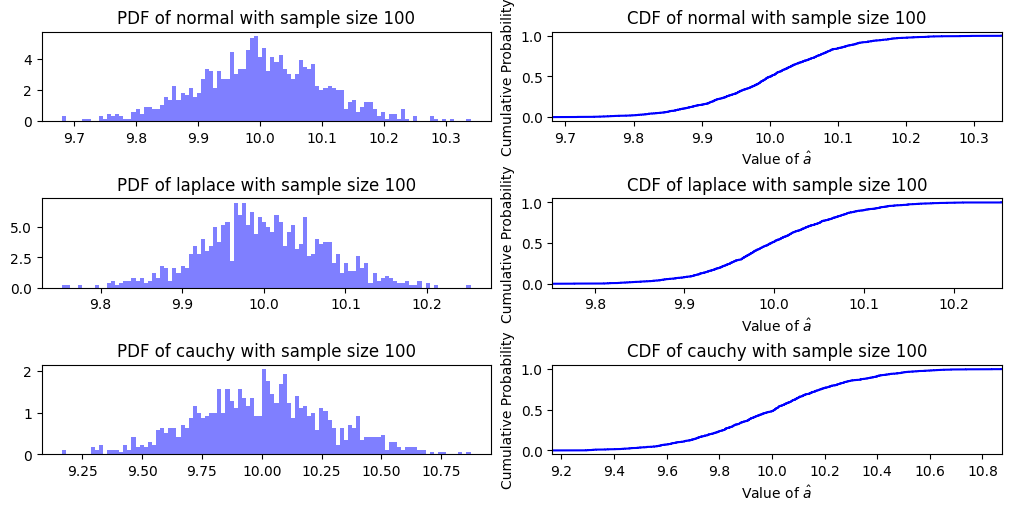

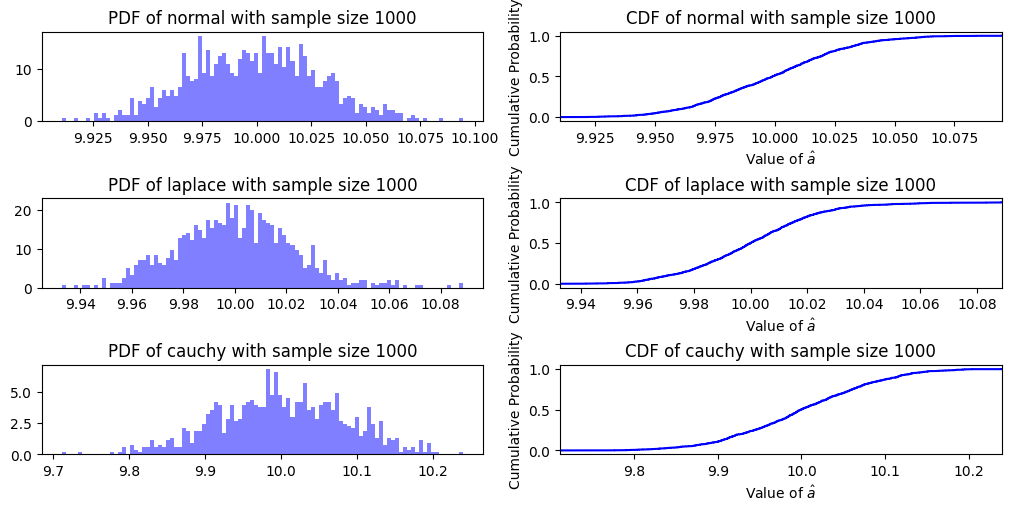

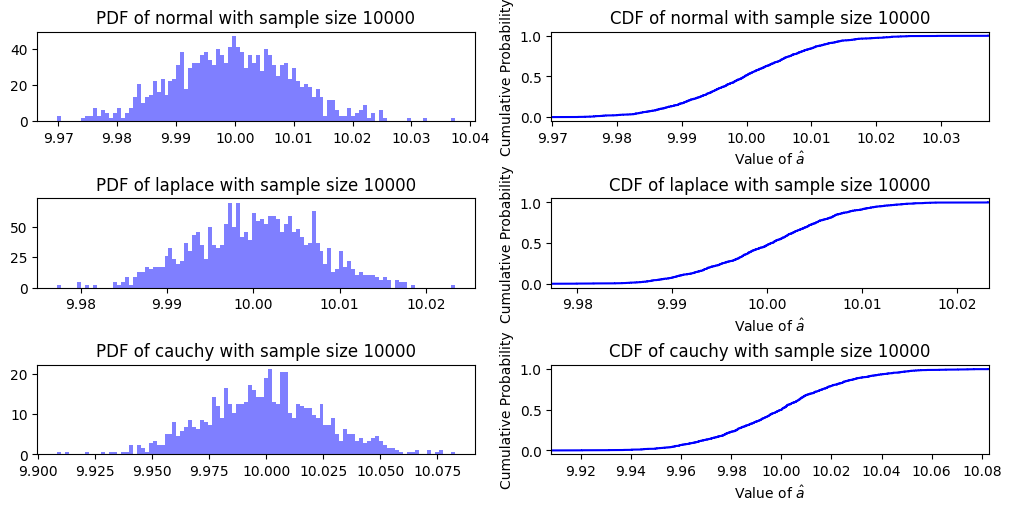

In [32]:
plot_cdf_pdf(n, 10, estimates10, stats10)